## 신용대출 심사

- 이번에 제공한 예측 모델의 정확도가 높아 상당히 만족스럽습니다. 그런데 궁금한 점이 있습니다. 모델이 신용도를 예측하는데 중요한 요인은 무엇인가요?

### 1. 환경준비

In [1]:
# 라이브러리 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.backend import clear_session

In [2]:
# 데이터 로딩
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/credit_all.csv'
data = pd.read_csv(path)
data.loc[data['Payment'] == 4, 'Payment'] = 3
data.head()

,Creditability,AccountBalance,Duration,Payment,Purpose,CreditAmount,Employment,SexMarital,CurrentAddress,MostValuableAsset,Age,Apartment,CreditCount,Occupation,Dependents,Telephone,ForeignWorker
0,1,3,24,2,0,1249,2,4,2,1,28,2,1,3,1,1,1
1,1,2,9,2,0,276,3,4,4,1,22,1,1,2,1,1,1
2,1,1,18,3,2,1049,2,2,4,2,21,1,1,3,1,1,1
3,1,1,24,3,1,6419,5,2,4,4,44,3,2,4,2,2,1
4,1,3,12,2,2,1424,5,2,4,1,55,2,1,4,1,2,1


In [3]:
data.shape

(1000, 17)

1    700
0    300
Name: Creditability, dtype: int64
1    0.7
0    0.3
Name: Creditability, dtype: float64


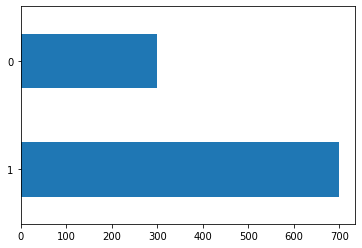

In [4]:
# target
print(data['Creditability'].value_counts())
print(data['Creditability'].value_counts()/ data.shape[0])

data['Creditability'].value_counts().plot(kind = 'barh')
plt.show()

### 2. 데이터 준비

In [5]:
# x, y split
target = 'Creditability'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

In [6]:
# dummy variable
dummy_vars = ['Employment', 'CurrentAddress', 'CreditCount', 'Dependents', 'Telephone', 'AccountBalance', 'Payment', 'Purpose', 'SexMarital', 'MostValuableAsset', 'Apartment','Occupation','ForeignWorker']

x = pd.get_dummies(x, columns = dummy_vars)
x.head()

,Duration,CreditAmount,Age,Employment_1,Employment_2,Employment_3,Employment_4,Employment_5,CurrentAddress_1,CurrentAddress_2,...,MostValuableAsset_4,Apartment_1,Apartment_2,Apartment_3,Occupation_1,Occupation_2,Occupation_3,Occupation_4,ForeignWorker_1,ForeignWorker_2
0,24,1249,28,0,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
1,9,276,22,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,18,1049,21,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
3,24,6419,44,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,1,0
4,12,1424,55,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,1,0


In [7]:
# train, valid split
from sklearn.model_selection import train_test_split

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 2022)

### 3. 트리 모델의 변수 중요도

- 성능이 가장 좋은 모델 선정.
- 성능이 가장 좋은 모델의 변수 중요도와 그렇지 않은 모델의 변수 중요도를 비교.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

In [10]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

In [11]:
# Decision Tree
params = {'max_depth':range(1, 10)}

model1 = GridSearchCV(DecisionTreeClassifier(), params, cv = 5)
model1.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 10)})

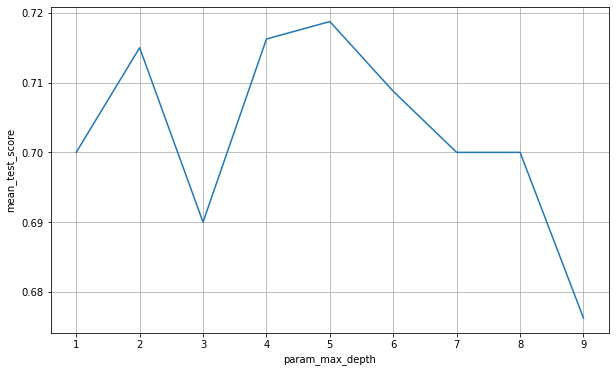

In [12]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(model1.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

In [13]:
# Random Forest
model2 = RandomForestClassifier()
model2.fit(x_train, y_train)

RandomForestClassifier()

In [14]:
# XGB
params = {'max_depth':range(1, 6), 'learning_rate':np.linspace(0.01,0.4, 10)
            , 'n_estimators':[50,100,150]}

model3 = GridSearchCV(XGBClassifier(), params, cv = 5)
model3.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'learning_rate': array([0.01      , 0.05333333, 0.09666667, 0.14      , 0.18333333,
       0.22666667, 0.27      , 0.31333333, 0.35666667, 0.4       ]),
                         'max_depth': range(1, 6),
                         'n_estimators': [50, 100, 150]})

In [15]:
# 모델 성능 비교
pred1 = model1.predict(x_val)
pred2 = model2.predict(x_val)
pred3 = model3.predict(x_val)

In [16]:
print(confusion_matrix(y_val, pred1 ))
print(classification_report(y_val, pred1 ))

[[ 35  25]
 [ 31 109]]
              precision    recall  f1-score   support

           0       0.53      0.58      0.56        60
           1       0.81      0.78      0.80       140

    accuracy                           0.72       200
   macro avg       0.67      0.68      0.68       200
weighted avg       0.73      0.72      0.72       200



In [17]:
print(confusion_matrix(y_val, pred2 ))
print(classification_report(y_val, pred2 ))

[[ 25  35]
 [ 24 116]]
              precision    recall  f1-score   support

           0       0.51      0.42      0.46        60
           1       0.77      0.83      0.80       140

    accuracy                           0.70       200
   macro avg       0.64      0.62      0.63       200
weighted avg       0.69      0.70      0.70       200



In [18]:
print(confusion_matrix(y_val, pred3 ))
print(classification_report(y_val, pred3 ))

[[ 28  32]
 [ 27 113]]
              precision    recall  f1-score   support

           0       0.51      0.47      0.49        60
           1       0.78      0.81      0.79       140

    accuracy                           0.70       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.70      0.70      0.70       200



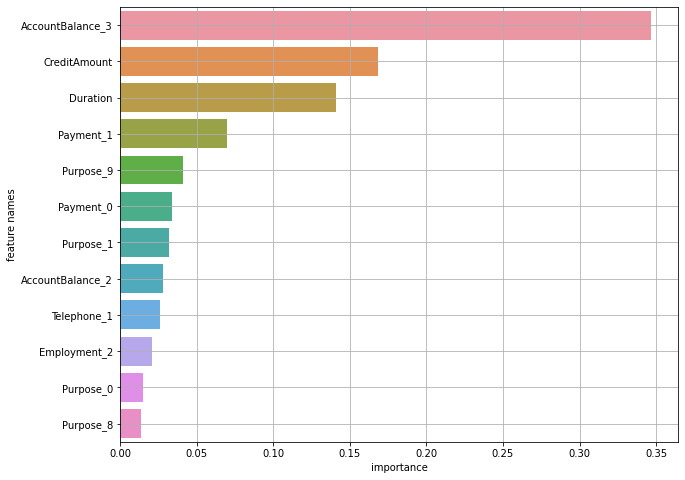

In [19]:
# 변수 중요도 비교
result1 = plot_feature_importance(model1.best_estimator_.feature_importances_, list(x),12)

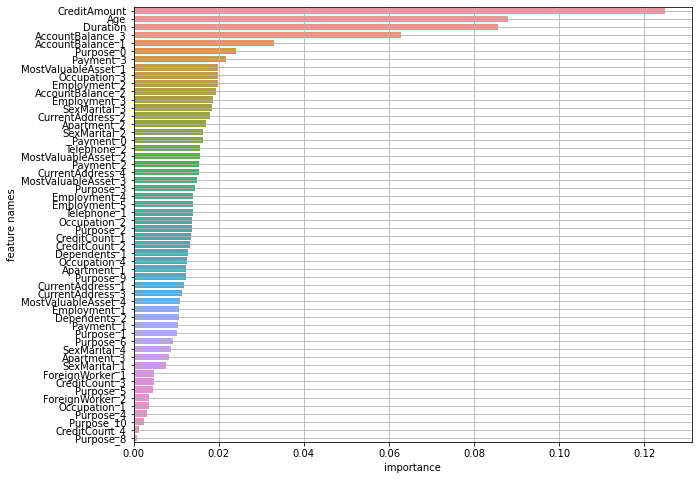

In [20]:
result2 = plot_feature_importance(model2.feature_importances_, list(x))

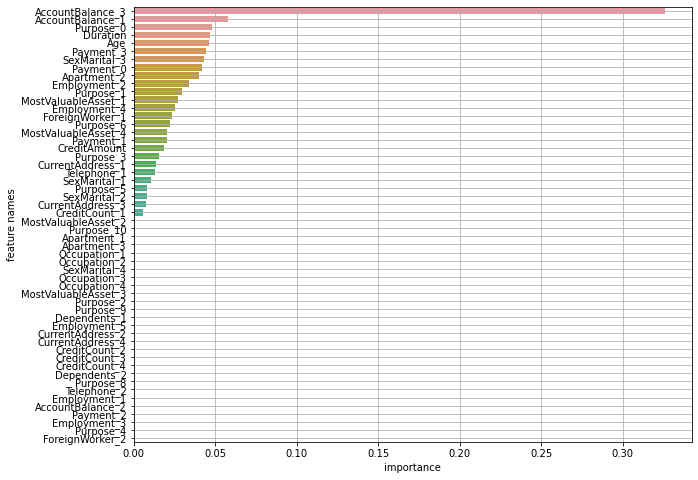

In [21]:
result3 = plot_feature_importance(model3.best_estimator_.feature_importances_, list(x))

### 4. Permutation Feature Importance

In [22]:
from sklearn.inspection import permutation_importance

In [23]:
# scaling
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

In [24]:
# svm
params = {'C':[0.1,0.5,1,2,5,10]}

model4 = GridSearchCV(SVC(), params, cv = 5)
model4.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.1, 0.5, 1, 2, 5, 10]})

In [25]:
pfi1 = permutation_importance(model4, x_val_s, y_val, n_repeats=10, scoring = 'accuracy', random_state=2022)

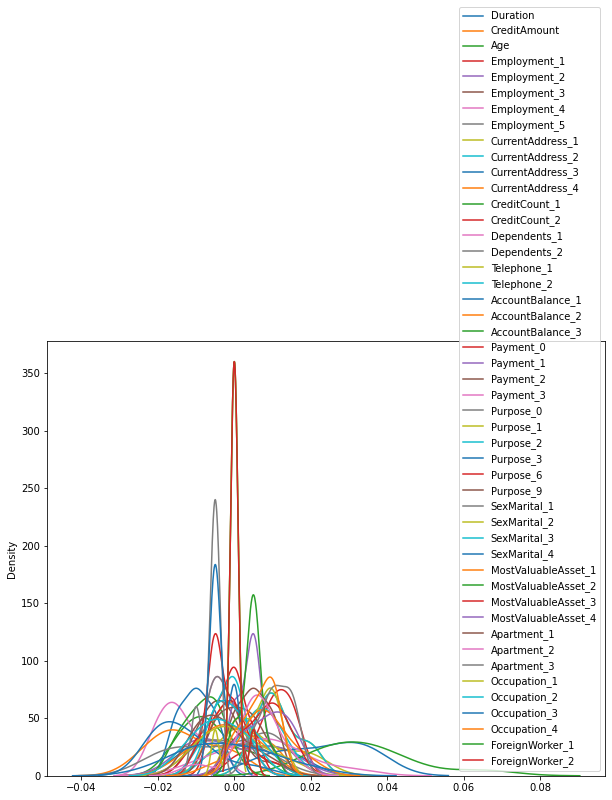

In [26]:
plt.figure(figsize = (10,8))
for i,vars in enumerate(list(x)) :
    sns.kdeplot(pfi1.importances[i], label = vars)

plt.legend()
plt.show()

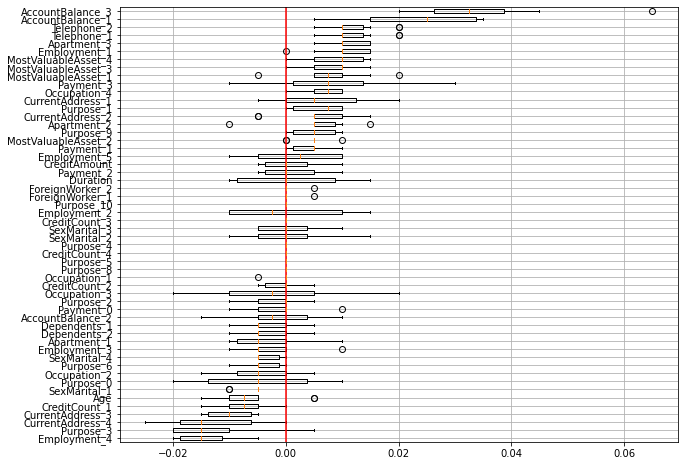

In [27]:
sorted_idx = pfi1.importances_mean.argsort()
plt.figure(figsize = (10, 8))
plt.boxplot(pfi1.importances[sorted_idx].T, vert=False, labels=x.columns[sorted_idx])
plt.axvline(0, color = 'r')
plt.grid()
plt.show()

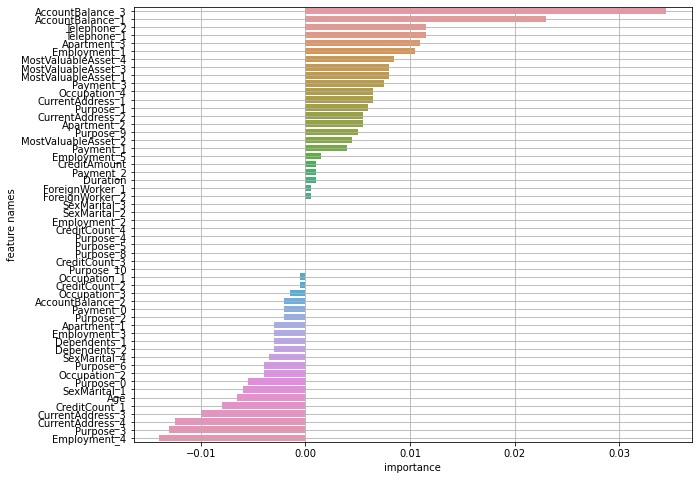

In [28]:
result = plot_feature_importance(pfi1.importances_mean, list(x_train))

In [29]:
pred4 = model4.predict(x_val_s)
print(confusion_matrix(y_val, pred4 ))
print(classification_report(y_val, pred4 ))

[[ 29  31]
 [ 28 112]]
              precision    recall  f1-score   support

           0       0.51      0.48      0.50        60
           1       0.78      0.80      0.79       140

    accuracy                           0.70       200
   macro avg       0.65      0.64      0.64       200
weighted avg       0.70      0.70      0.70       200



In [30]:
# Deep Learning
nfeatures = x_train_s.shape[1]
clear_session()

model5 = Sequential([Dense(32, input_shape = [nfeatures,], activation = 'swish'),
                     Dense(16, activation = 'swish'),
                     Dense(1, activation = 'sigmoid')
                     ])

model5.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001), loss = 'binary_crossentropy')
history = model5.fit(x_train_s, y_train, epochs = 150, validation_split = .2).history

Epoch 1/150
20/20 [==============================] - 4s 13ms/step - loss: 0.6838 - val_loss: 0.6894
Epoch 2/150
20/20 [==============================] - 0s 4ms/step - loss: 0.6740 - val_loss: 0.6823
Epoch 3/150
20/20 [==============================] - 0s 4ms/step - loss: 0.6646 - val_loss: 0.6760
Epoch 4/150
20/20 [==============================] - 0s 4ms/step - loss: 0.6563 - val_loss: 0.6701
Epoch 5/150
20/20 [==============================] - 0s 4ms/step - loss: 0.6483 - val_loss: 0.6650
Epoch 6/150
20/20 [==============================] - 0s 4ms/step - loss: 0.6410 - val_loss: 0.6603
Epoch 7/150
20/20 [==============================] - 0s 4ms/step - loss: 0.6346 - val_loss: 0.6560
Epoch 8/150
20/20 [==============================] - 0s 4ms/step - loss: 0.6281 - val_loss: 0.6524
Epoch 9/150
20/20 [==============================] - 0s 4ms/step - loss: 0.6227 - val_loss: 0.6490
Epoch 10/150
20/20 [==============================] - 0s 4ms/step - loss: 0.6175 - val_loss: 0.6461
Epoch 11

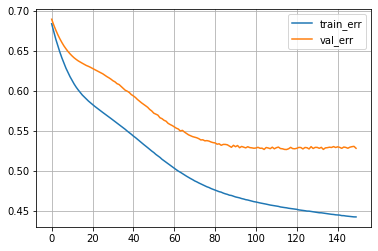

In [31]:
plt.plot(history['loss'], label = 'train_err')
plt.plot(history['val_loss'], label = 'val_err')
plt.grid()
plt.legend()
plt.show()

In [32]:
pfi2 = permutation_importance(model5, x_val_s, y_val, n_repeats=10, scoring = 'r2', random_state=2022)

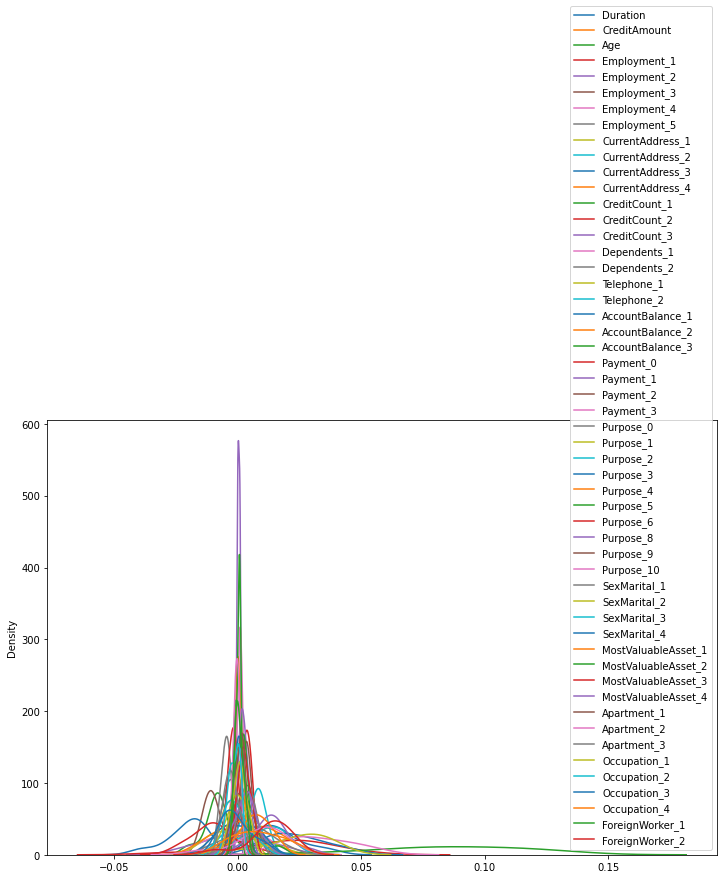

In [33]:
plt.figure(figsize = (12,8))
for i,vars in enumerate(list(x)) :
    sns.kdeplot(pfi2.importances[i], label = vars)

plt.legend()
plt.show()

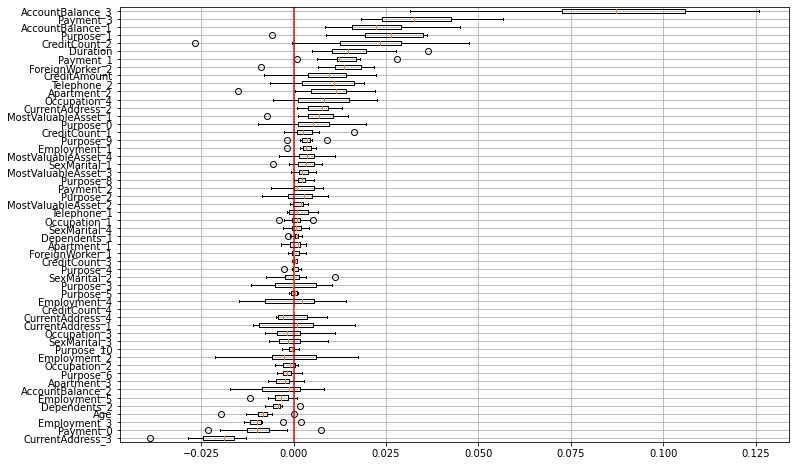

In [34]:
sorted_idx = pfi2.importances_mean.argsort()
plt.figure(figsize = (12,8))
plt.boxplot(pfi2.importances[sorted_idx].T, vert=False, labels=x.columns[sorted_idx])
plt.axvline(0, color = 'r')
plt.grid()
plt.show()

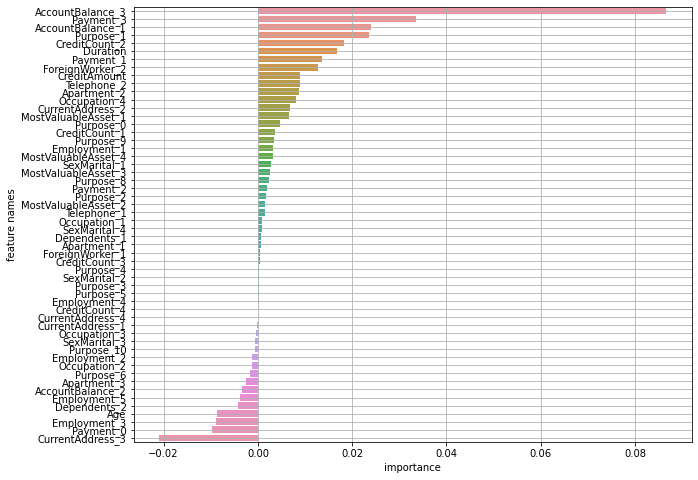

In [35]:
result = plot_feature_importance(pfi2.importances_mean, list(x_train))

In [36]:
pred5 = model5.predict(x_val_s)
pred5 = np.where(pred5 >= .5, 1, 0)

print(confusion_matrix(y_val, pred5))
print(classification_report(y_val, pred5))

[[ 26  34]
 [ 26 114]]
              precision    recall  f1-score   support

           0       0.50      0.43      0.46        60
           1       0.77      0.81      0.79       140

    accuracy                           0.70       200
   macro avg       0.64      0.62      0.63       200
weighted avg       0.69      0.70      0.69       200



#### 성능비교

In [37]:
print(confusion_matrix(y_val, pred1))
print(classification_report(y_val, pred1))

print(confusion_matrix(y_val, pred2))
print(classification_report(y_val, pred2))

print(confusion_matrix(y_val, pred3))
print(classification_report(y_val, pred3))

print(confusion_matrix(y_val, pred4))
print(classification_report(y_val, pred4))

print(confusion_matrix(y_val, pred5))
print(classification_report(y_val, pred5))

[[ 35  25]
 [ 31 109]]
              precision    recall  f1-score   support

           0       0.53      0.58      0.56        60
           1       0.81      0.78      0.80       140

    accuracy                           0.72       200
   macro avg       0.67      0.68      0.68       200
weighted avg       0.73      0.72      0.72       200

[[ 25  35]
 [ 24 116]]
              precision    recall  f1-score   support

           0       0.51      0.42      0.46        60
           1       0.77      0.83      0.80       140

    accuracy                           0.70       200
   macro avg       0.64      0.62      0.63       200
weighted avg       0.69      0.70      0.70       200

[[ 28  32]
 [ 27 113]]
              precision    recall  f1-score   support

           0       0.51      0.47      0.49        60
           1       0.78      0.81      0.79       140

    accuracy                           0.70       200
   macro avg       0.64      0.64      0.64       200
weigh

### 5. PDP

- 중요한 feature 값에 따라 예측값이 어떻게 달라지는지?
- 각 변수의 값들 변화에 따라 예측값은 어떻게 달라지는지?
- 두 변수의 조합으로 예측값과의 관계를 살펴보기.

In [38]:
from sklearn.inspection import plot_partial_dependence, partial_dependence

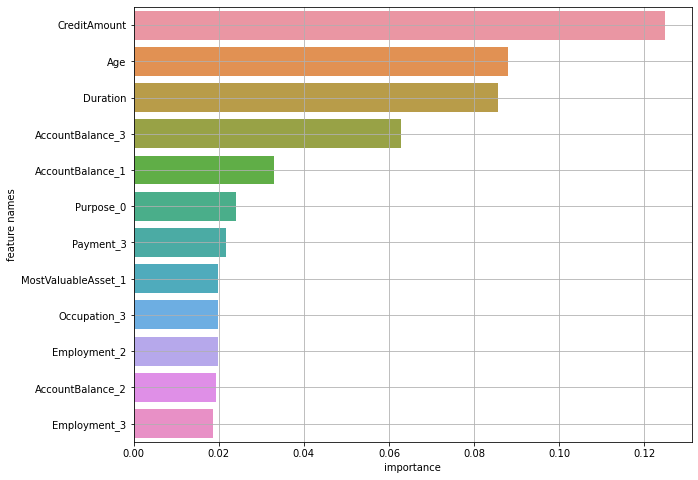

In [39]:
r2 = plot_feature_importance(model2.feature_importances_, list(x),12)

In [40]:
plt.rcParams['figure.figsize'] = 10, 6

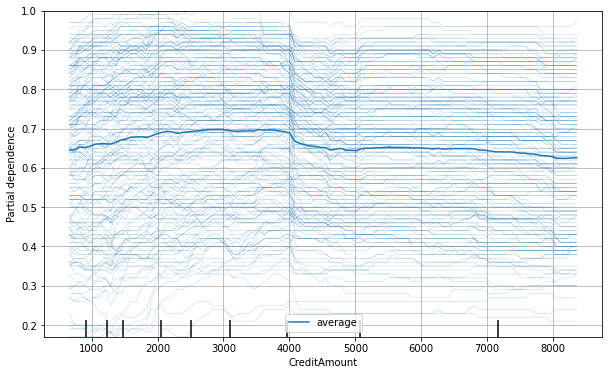

In [41]:
# CreditAmount
var = 'CreditAmount'

plot_partial_dependence(model2, features = [var], X = x_val, kind = 'both')
plt.grid()
plt.show()

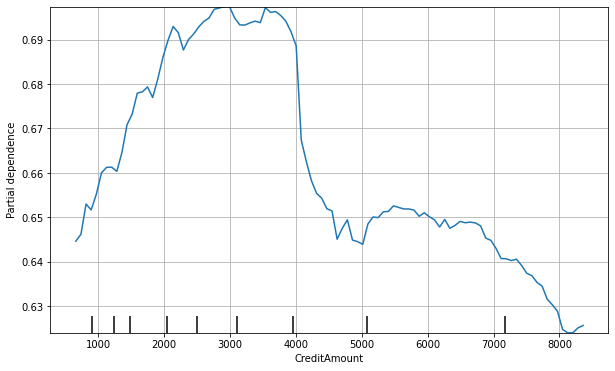

In [42]:
plot_partial_dependence(model2, features = [var], X = x_val, kind = 'average')
plt.grid()
plt.show()

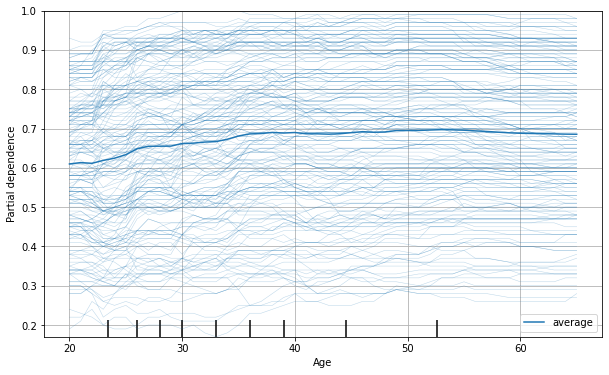

In [43]:
# Age
var = 'Age'

plot_partial_dependence(model2, features = [var], X = x_val, kind = 'both')
plt.grid()
plt.show()

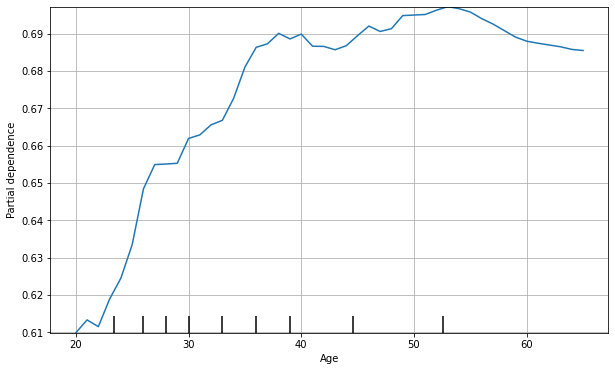

In [44]:
plot_partial_dependence(model2, features = [var], X = x_val, kind = 'average')
plt.grid()
plt.show()

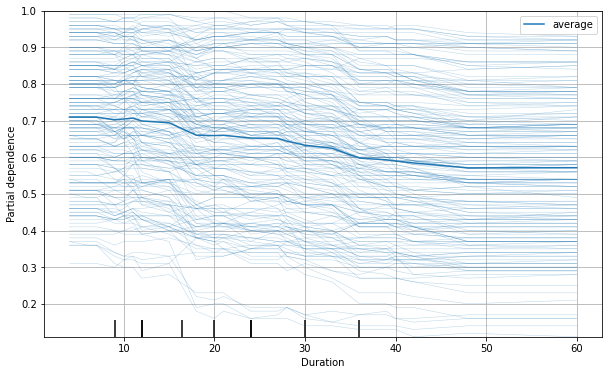

In [45]:
# Duration
var = 'Duration'

plot_partial_dependence(model2, features = [var], X = x_val, kind = 'both')
plt.grid()
plt.show()

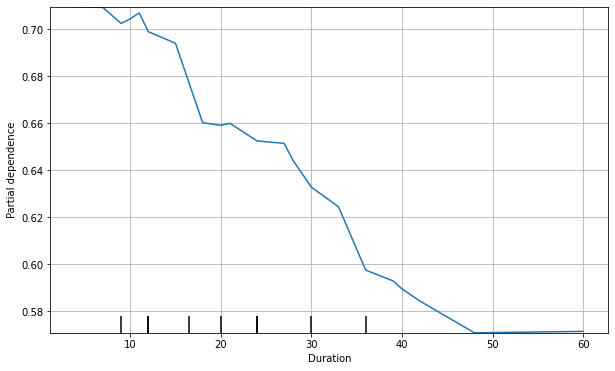

In [46]:
plot_partial_dependence(model2, features = [var], X = x_val, kind = 'average')
plt.grid()
plt.show()

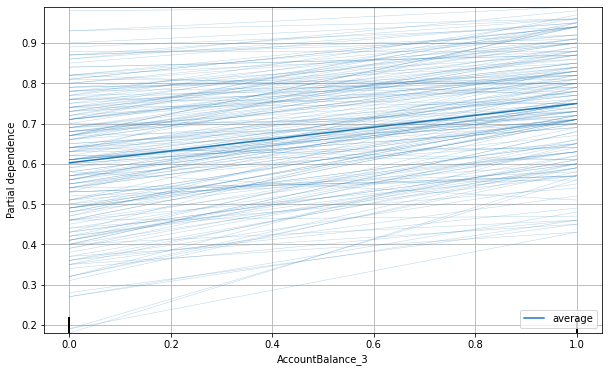

In [47]:
# AccountBalance_3
var = 'AccountBalance_3'

plot_partial_dependence(model2, features = [var], X = x_val, kind = 'both')
plt.grid()
plt.show()

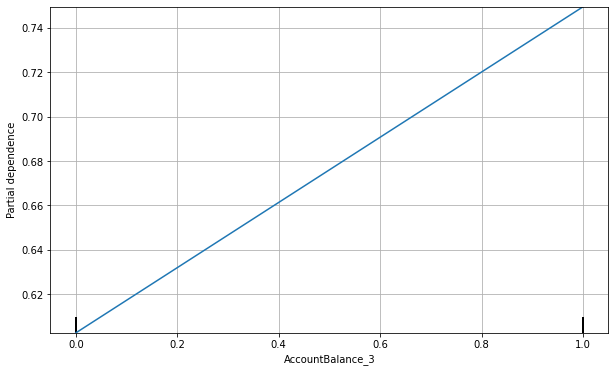

In [48]:
plot_partial_dependence(model2, features = [var], X = x_val, kind = 'average')
plt.grid()
plt.show()

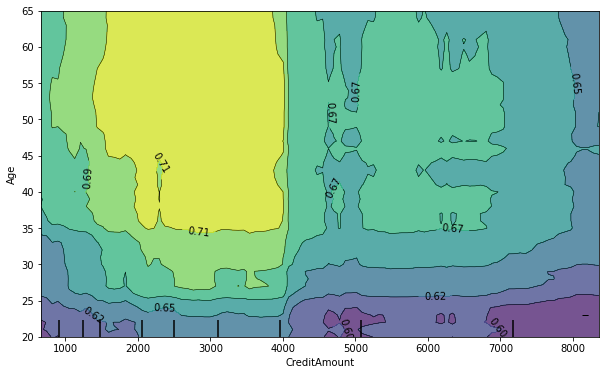

In [49]:
# 조합1
plot_partial_dependence(model2, features = [('CreditAmount','Age')], X = x_val)
plt.show()

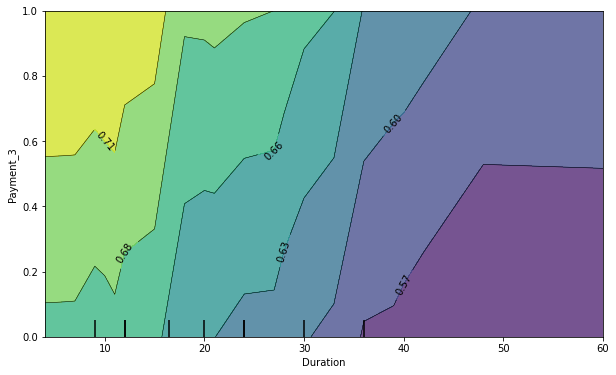

In [50]:
# 조합2
plot_partial_dependence(model2, features = [('Duration','Payment_3')], X = x_val)
plt.show()